In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib
import hvplot
import hvplot.pandas
import plotly.graph_objects as go
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from arch import arch_model
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [3]:
def get_volaitlity(df, window):
    """compute historical volatility/standard deviations 
    of close price returns over last N days (window) and that can be used to predict volatility for the next day"""
    df['hist_vol']=np.nan
    volatility = []
    for i in range(window, len(df['returns'])):
        volatility.append(np.std(df['returns'][i-window:i]))
    df.loc[window:, 'hist_vol'] = volatility
    df.dropna(inplace=True)
    return df

In [4]:
def train_model(train, test, model, order, fname):
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        if model=='GARCH':
            def_model = arch_model(data, vol=model, rescale = False, dist='gaussian', mean="Zero",
                                   p=order[0], o=order[1], q=order[1])
        else:
            def_model = model(history, order=order)
        model_fit = def_model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    model_fit.save(fname)
    return predictions

In [21]:
def get_acc_measures(actual, prediction):
    MSE = np.abs(mean_squared_error(actual, prediction))
    RMSE = np.sqrt(MSE)
    MAE = np.mean(np.abs(prediction - actual))
    MAPE = (np.mean(np.abs((actual - prediction) / actual)))
    Acc_score= f'MSE: {round(MSE, 4)};  RMSE: {round(RMSE, 4)}: MAE:  {round(MAE, 4)}; MAPE:  {round(MAPE, 4)}'
    return Acc_score

In [6]:
# Plot the predicted (from ARIMA) and real prices
def get_results_plot(actual, predicted, title):
    plt.figure(figsize=(10, 5))
    plt.plot(actual, label='Real')
    plt.plot(predicted, color='red', label='Predicted')
    plt.xlabel('Days')
    plt.ylabel('Index')
    plt.title(title)
    plt.legend()
    plt.show()

In [7]:
data_file='./resources/IBM_close.csv'
df_ibm = pd.read_csv(data_file, parse_dates=True, infer_datetime_format=True, index_col='Date')#, delimiter=',')
df_ibm.head()

,Close,Volume
Date,,
2017-01-03 16:00:00,167.19,2934119
2017-01-04 16:00:00,169.26,3381432
2017-01-05 16:00:00,168.70,2682181
2017-01-06 16:00:00,169.53,2945536
2017-01-09 16:00:00,167.65,3189413


In [8]:
df_ibm['returns'] = df_ibm['Close'].pct_change()
#df_ibm.fillna(0., inplace=True)
df_ibm.dropna(inplace=True)

In [9]:
df_ibm= get_volaitlity(df_ibm, 5)

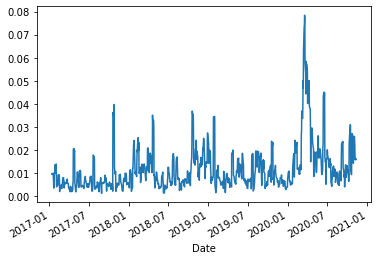

In [10]:
df_ibm['hist_vol'].plot()

In [11]:
#use 1 year data back from nov 1st 2020
train = df_ibm['2017-11-01': '2019-11-01']
df_ibm_20 = df_ibm['2019-11-01': '2020-11-01']
test=df_ibm_20.copy()

# Auto Correlation Coefficients

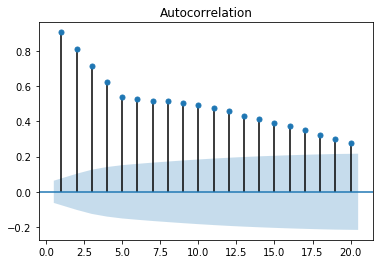

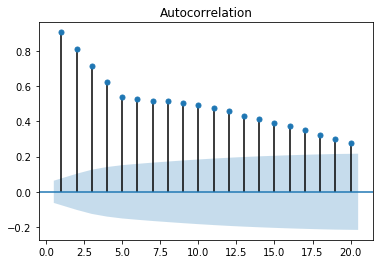

In [12]:
# we will use PACF to identify optimal lags for our ARMA and ARIMA models with 30 day lags
plot_acf(df_ibm['hist_vol'], lags=20, zero=False)

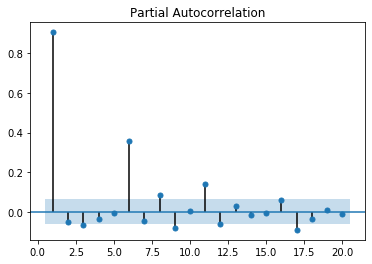

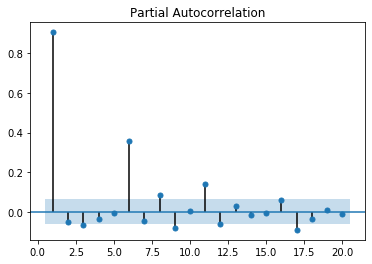

In [13]:
plot_pacf(df_ibm['hist_vol'], lags=20, zero=False)

# ARMA Model

In [14]:
# initiate ARMA Model
arma_model = ARMA(train['hist_vol'], order=(1,1))
arma_vol=arma_model.fit()
arma_vol.summary()
#arma_vol.forecast()[0]

/Users/philonoun/anaconda3/envs/pyvizenz/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               hist_vol   No. Observations:                  504
Model:                     ARMA(1, 1)   Log Likelihood                2087.037
Method:                       css-mle   S.D. of innovations              0.004
Date:                Mon, 16 Nov 2020   AIC                          -4166.074
Time:                        19:22:54   BIC                          -4149.184
Sample:                             0   HQIC                         -4159.449
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0108      0.001     11.886      0.000       0.009       0.013
ar.L1.hist_vol     0.7974      0.031     25.660      0.000       0.736       0.858
ma.L1.hist_vol     0.0845      0.047      1.803      0.071      -0.007       0.176
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2541           +0.0000j            1.2541            0.0000
MA.1          -11.8398           +0.0000j           11.8398            0.5000
-----------------------------------------------------------------------------
"""

In [18]:
#train ARMA model
order=(1,1)
filename='arma_ibmvix.pkl'
arma_pred = train_model(train['hist_vol'], test['hist_vol'], ARMA, order, filename)

/Users/philonoun/anaconda3/envs/pyvizenz/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [23]:
get_acc_measures(test['hist_vol'].values, arma_pred)

'MSE: 0.0;  RMSE: 0.0054: MAE:  0.0137; MAPE:  1.0712'

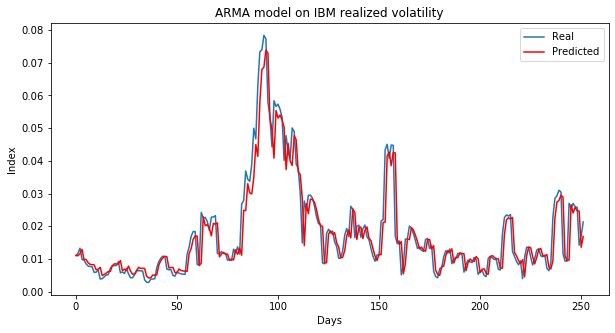

In [24]:
title='ARMA model on IBM realized volatility'
get_results_plot(test['hist_vol'].values, arma_pred, title)

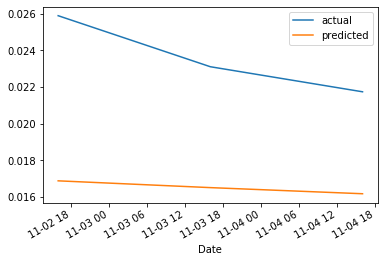

In [25]:
#make predictions
from statsmodels.tsa.arima_model import ARIMAResults
arma_model = ARIMAResults.load('arma_ibmvix.pkl')
forecast = arma_model.forecast(steps=3)[0]
data_to_pred = df_ibm['hist_vol']['2020-11-01':'2020-11-04']
pred_df = pd.DataFrame({'actual': data_to_pred, 'predicted': forecast})
pred_df.plot()

In [26]:
get_acc_measures(pred_df.actual.values, pred_df.predicted.values)

'MSE: 0.0001;  RMSE: 0.0072: MAE:  0.0071; MAPE:  0.2972'

# ARIMA Model - Univariate Time series

In [27]:
# model = ARIMA(df_ibm_20['Close'].values, order=(3,2,1))
# arima_vol=model.fit()
# arima_vol.summary()
data = df_ibm['hist_vol'].values
model = ARIMA(data, order=(4, 1, 1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  965
Model:                 ARIMA(4, 1, 1)   Log Likelihood                3905.816
Method:                       css-mle   S.D. of innovations              0.004
Date:                Mon, 16 Nov 2020   AIC                          -7797.632
Time:                        19:28:02   BIC                          -7763.527
Sample:                             1   HQIC                         -7784.648
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.012e-05   6.32e-05      0.160      0.873      -0.000       0.000
ar.L1.D.y      0.7512      0.057     13.277      0.000       0.640       0.862
ar.L2.D.y      0.0136      0.040      0.341      0.7

In [28]:
order = (4, 1, 1)
filename='arima_ibmvix.pkl'
arima_pred = train_model(train['hist_vol'], test['hist_vol'], ARIMA, order, filename)

In [29]:
get_acc_measures(test['hist_vol'].values, arima_pred)

'MSE: 0.0;  RMSE: 0.0053: MAE:  0.0142; MAPE:  1.1222'

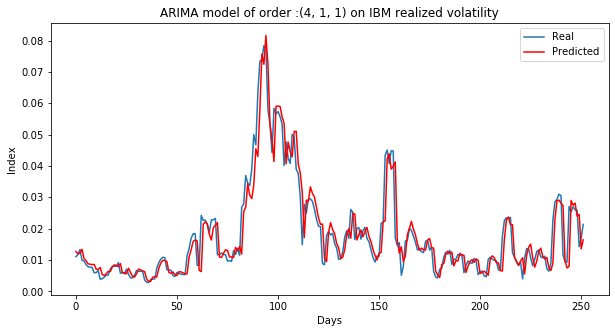

In [30]:
title='ARIMA model of order :' + f'{order}' + ' on IBM realized volatility'
get_results_plot(test['hist_vol'].values, arima_pred, title)

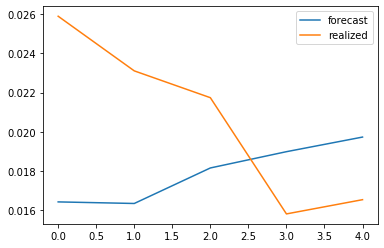

In [31]:
arima_model = ARIMAResults.load('arima_ibmvix.pkl')
fcast=arima_model.forecast(steps=5)[0]
realized=df_ibm['hist_vol']['2020-11-01':'2020-11-06'].values
results=pd.DataFrame({'forecast':fcast, 'realized':realized})
results.plot()

# GARCH Model

In [32]:
# Estimating a GARCH model:
data=df_ibm['returns']
garch_model = arch_model(data, vol='GARCH', rescale = False, dist='gaussian', mean="Zero", p=1, o=1, q=1)
arch_vol = garch_model.fit(disp="off")
arch_vol.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Zero Mean - GJR-GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                  GJR-GARCH   Log-Likelihood:                2702.63
Distribution:                  Normal   AIC:                          -5397.26
Method:            Maximum Likelihood   BIC:                          -5377.77
                                        No. Observations:                  966
Date:                Mon, Nov 16 2020   Df Residuals:                      962
Time:                        19:33:50   Df Model:                            4
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.9932e-05  1.358e-06     22.044 1.083e-107 [2.727e-05,3.259e-05]
alpha[1]       0.1000  7.308e-02      1.368      0.171  [-4.324e-02,  0.243]
gamma[1]       0.1000      0.105      0.956      0.339     [ -0.105,  0.305]
beta[1]        0.7500  4.922e-02     15.238  1.964e-52     [  0.654,  0.846]
============================================================================

Covariance estimator: robust
"""

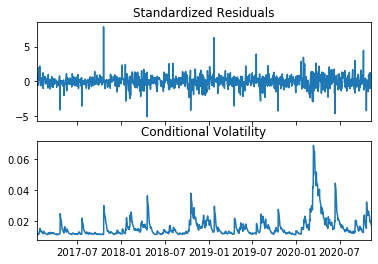

In [33]:
fig = arch_vol.plot()
fig.size=(20,5)

In [34]:
g_train = df_ibm['returns']['2017-11-01': '2019-11-01']
g_test = df_ibm['hist_vol']['2019-11-01':]
#order = (1, 1, 1)
#filename='garch_ibmvix.pkl'

In [35]:
g_hist = [x for x in g_train]
g_pred = []
for t in range(len(g_test)):
    model = arch_model(g_hist, vol='GARCH', rescale = False, dist='gaussian', 
                       mean="Zero", p=1, o=1, q=1)
    model_fit = model.fit(disp='off')
    output = model_fit.forecast()
    t_output = np.sqrt(output.variance.dropna())
    yhat = t_output.dropna().T
    g_pred.append(yhat)
    obs = g_test[t]
    g_hist.append(obs)

In [36]:
pred=[]
for i in range(len(g_pred)):
    pred.append(g_pred[i][503+i].values.ravel())

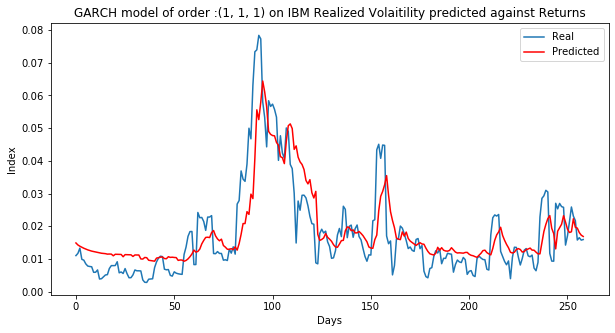

In [37]:
title='GARCH model of order :' + f'{1, 1, 1}' + ' on IBM Realized Volaitility predicted against Returns'
get_results_plot(g_test.values, pred, title)

In [38]:
last_day = df_ibm_20['returns'].index.max().date()#.strftime('%Y-%m-%d')
forecast_horizon = 5
last_day
forecasts = model_fit.forecast(start=last_day, horizon=forecast_horizon, )
intermediate = np.sqrt(forecasts.variance.dropna())
# predicted = intermediate.dropna().T

In [134]:
#predicted = predicted['2020-10-30 16:00:00'].values
#df_ibm['Close']['2020-11-01':].values
#intermediate

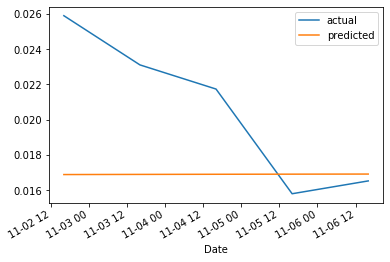

In [39]:
arch_results = pd.DataFrame({'actual': df_ibm['hist_vol']['2020-11-01':'2020-11-06'].values, 
                             'predicted':intermediate.loc[761].values},
                            index=df_ibm['returns']['2020-11-01':'2020-11-06'].index)
arch_results.plot()

# Multivaiate Timeseries prediction using Vector Auto Regression

### Using VAR model will predict multiple features based on historical observations. 

In [43]:
data_file='resources/iv_data/IBMVIX.txt'
df = pd.read_csv(data_file, parse_dates=True, infer_datetime_format=True, delimiter=',', index_col='Date')#, delimiter=',')
df.head()

,Time,Open,High,Low,Close,Vol,OI,Avg
Date,,,,,,,,
2010-11-08,15:02,20.12,20.13,19.15,19.17,0,0,0.0
2010-11-09,15:02,18.51,20.09,18.51,20.02,0,0,0.0
2010-11-10,15:02,20.22,20.53,19.98,19.98,0,0,0.0
2010-11-11,15:02,20.83,21.15,20.29,20.30,0,0,0.0
2010-11-12,15:02,20.78,21.42,20.40,21.29,0,0,0.0


In [44]:
vix_df=df[['Close']]
vix_df.columns=['VIX']
vix_df=vix_df['2017-01-11 ':]

In [45]:
temp_df=df_ibm[: '2020-11-06']
temp_df.index = pd.to_datetime(temp_df.index.date, format='%Y/%m/%d')
temp_df.head()

,Close,Volume,returns,hist_vol
2017-01-11,167.75,3599464,0.013473,0.009525
2017-01-12,167.95,2927953,0.001192,0.009858
2017-01-13,167.34,2875319,-0.003632,0.009879
2017-01-17,167.89,3315305,0.003287,0.009465
2017-01-18,166.80,4005776,-0.006492,0.008577


In [46]:
var_df=pd.concat([vix_df, temp_df], axis=1)
var_df.dropna(inplace=True)
var_df.head()

,VIX,Close,Volume,returns,hist_vol
2017-01-11,25.13,167.75,3599464,0.013473,0.009525
2017-01-12,24.65,167.95,2927953,0.001192,0.009858
2017-01-13,24.87,167.34,2875319,-0.003632,0.009879
2017-01-17,24.10,167.89,3315305,0.003287,0.009465
2017-01-18,24.31,166.80,4005776,-0.006492,0.008577


In [139]:
#data=np.column_stack([var_df.loc[:, column] for column in var_df.columns])

In [47]:
#Check stationarity using coint johansen method. Dickey fuller test is only for univariate time series

def cj_output(res):
    output = pd.DataFrame([res.lr2,res.lr1],
                          index=['max_eig_stat',"trace_stat"])
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')
    plt.plot(np.dot(var_df,res.cvt))
    plt.show()

   max_eig_stat  trace_stat
0    440.315254  826.870538
1    244.984231  386.555284
2    108.320354  141.571053
3     19.114061   33.250700
4     14.136638   14.136638 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[34.4202 37.1646 42.8612]
 [28.2398 30.8151 36.193 ]
 [21.8731 24.2522 29.2631]
 [15.0006 17.1481 21.7465]
 [ 2.7055  3.8415  6.6349]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[75.1027 79.3422 87.7748]
 [51.6492 55.2459 62.5202]
 [32.0645 35.0116 41.0815]
 [16.1619 18.3985 23.1485]
 [ 2.7055  3.8415  6.6349]] 



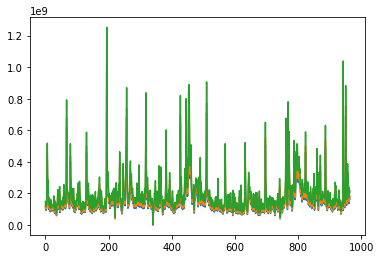

In [48]:
cj_model = coint_johansen(var_df, 1, 2)
cj_output(cj_model)

In [49]:
v_train = var_df[: '2019-11-01']
v_test=var_df['2019-11-01': '2020-11-01']

In [50]:
var_model = VAR(v_train, exog=None, dates=None, freq=None, missing=None)
model_fit = var_model.fit(maxlags=2, method='ols', ic='bic', trend='ct', verbose=False)
model_fit.summary()

/Users/philonoun/anaconda3/envs/pyvizenz/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 16, Nov, 2020
Time:                     19:35:36
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    7.64387
Nobs:                     706.000    HQIC:                   7.40610
Log likelihood:          -7510.35    FPE:                    1417.12
AIC:                      7.25637    Det(Omega_mle):         1302.59
--------------------------------------------------------------------
Results for equation VIX
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               4.379443         1.438361            3.045           0.002
trend               0.000081         0.000567            0.143           0.886
L1.VIX              0.542648         0.038197           14.206        

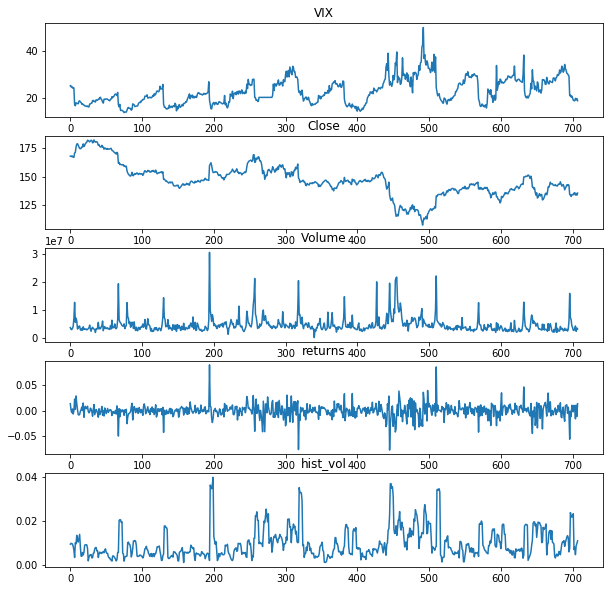

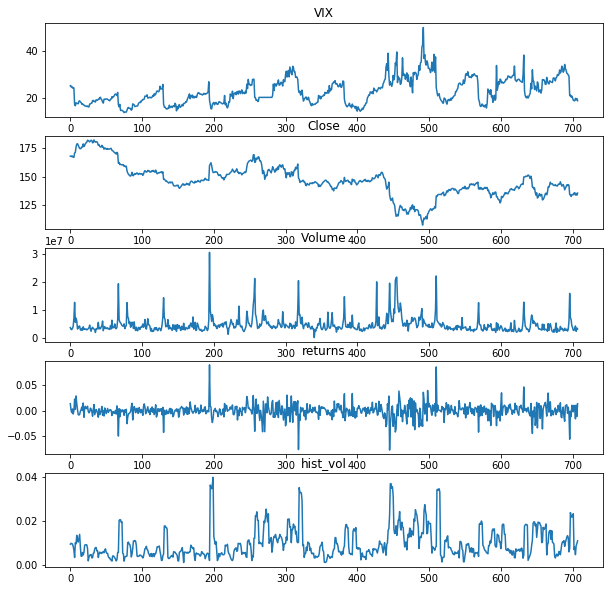

In [51]:
model_fit.plot()

In [52]:
len(var_df[:-5])

959

In [53]:
# Make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(model_fit.y))

In [ ]:
#capture preditions in a dataframe
cols = var_df.columns
pred = pd.DataFrame(index=range(0, len(prediction)), columns=[cols])

for j in range(0, len(cols)):
    for i in range(0, len(prediction)):
        pred.iloc[i][j] = prediction[i][j]

In [154]:
p_period = len(pred[['hist_vol']]) - len(var_df['hist_vol'])
p_period

-256

In [155]:
pred_results=pd.DataFrame({'predicted': pred[['hist_vol']].values.ravel(), 
                           'actual':var_df['hist_vol'][:p_period].values},
                          index=var_df['hist_vol'][:p_period].index)

<AxesSubplot:>

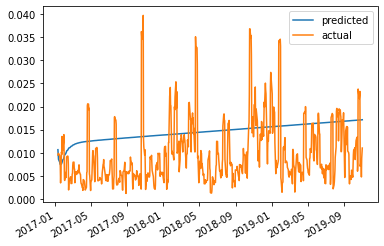

In [159]:
pred_results.plot()

In [160]:
#print RMSE for each of the predicted feature
for col in cols:
    print('RMSE value for', col, 'is:', np.sqrt(mean_squared_error(pred[[col]].values,
                var_df[col][:p_period].values)))

RMSE value for VIX is: 10.248285312092737
RMSE value for Close is: 31.186011485370532
RMSE value for Volume is: 2926717.3003807445
RMSE value for returns is: 0.013354583459296972
RMSE value for hist_vol is: 0.008114496437544914


In [161]:
#Make final predictions
model = VAR(endog=var_df[:'2020-10-30'])
model_fit = model.fit()
steps=5
yhat = model_fit.forecast(model_fit.y, steps=steps)

C:\Users\TinkerBell\anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [162]:
results=pd.DataFrame({'actual_IV': var_df['VIX'][-steps:], 'pred_IV': yhat[:,0],
                     'actual_close': var_df['Close'][-steps:], 'pred_close': yhat[:,1],
                     'actual_volume': var_df['Volume'][-steps:], 'pred_volume': yhat[:,2],
                     'actual_pc': var_df['returns'][-steps:], 'pred_pc': yhat[:,3],
                 'actual_RV': var_df['hist_vol'][-steps:], 'pred_RV': yhat[:,4]})

<AxesSubplot:title={'center':'next 5 days Realized Volatility'}>

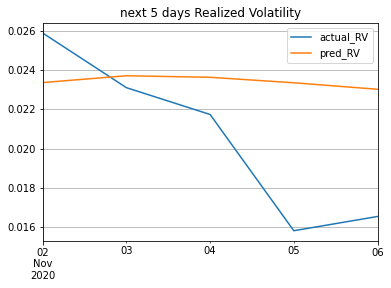

In [163]:
results[results.columns[8:10]].plot(title='next 5 days Realized Volatility', grid=True)

<AxesSubplot:title={'center':'next 5 days Implied Volatility'}>

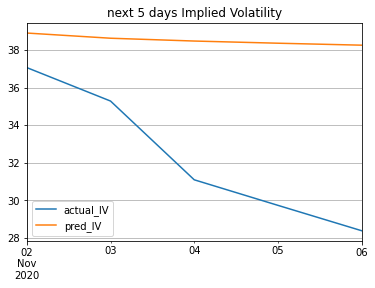

In [164]:
results[results.columns[0:2]].plot(title='next 5 days Implied Volatility', grid=True)

<AxesSubplot:title={'center':'next 5 days Stock Close Prices'}>

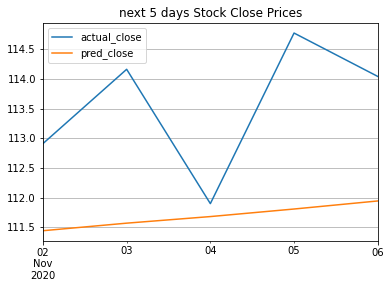

In [165]:
results[results.columns[2:4]].plot(title='next 5 days Stock Close Prices', grid=True)

<AxesSubplot:title={'center':'next 5 days Volume'}>

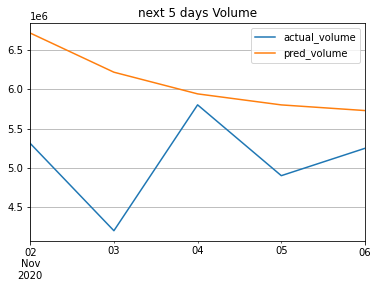

In [166]:
results[results.columns[4:6]].plot(title='next 5 days Volume', grid=True)

<AxesSubplot:title={'center':'next 5 days Return'}>

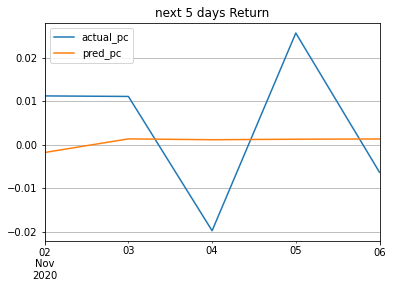

In [167]:
results[results.columns[6:8]].plot(title='next 5 days Return', grid=True)